In [1]:
from vllm import LLM

llm = LLM(
        model="Qwen/Qwen3-VL-Embedding-2B",
        runner="pooling",
        max_model_len=8192,        # Match official example
        quantization="mxfp4",
        gpu_memory_utilization=0.40,
        limit_mm_per_prompt={"image": 1},  # Official format
        enforce_eager=False
)

INFO 01-25 11:57:39 [utils.py:263] non-default args: {'runner': 'pooling', 'max_model_len': 8192, 'gpu_memory_utilization': 0.4, 'disable_log_stats': True, 'quantization': 'mxfp4', 'limit_mm_per_prompt': {'image': 1}, 'model': 'Qwen/Qwen3-VL-Embedding-2B'}
INFO 01-25 11:57:40 [model.py:859] Resolved `--convert auto` to `--convert embed`. Pass the value explicitly to silence this message.
INFO 01-25 11:57:40 [model.py:530] Resolved architecture: Qwen3VLForConditionalGeneration
INFO 01-25 11:57:40 [model.py:1545] Using max model len 8192
INFO 01-25 11:57:41 [scheduler.py:229] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 01-25 11:57:43 [vllm.py:630] Asynchronous scheduling is enabled.
INFO 01-25 11:57:43 [vllm.py:637] Disabling NCCL for DP synchronization when using async scheduling.
WARNING 01-25 11:57:43 [vllm.py:744] Pooling models do not support full cudagraphs. Overriding cudagraph_mode to PIECEWISE.
(EngineCore_DP0 pid=92570) INFO 01-25 11:57:45 [core.py:97] Ini

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


(EngineCore_DP0 pid=92570) INFO 01-25 11:58:00 [default_loader.py:291] Loading weights took 1.19 seconds
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:01 [gpu_model_runner.py:3905] Model loading took 4.31 GiB memory and 2.734098 seconds
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:01 [gpu_model_runner.py:4715] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 1 video items of the maximum feature size.
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:15 [backends.py:644] Using cache directory: /home/administrator/.cache/vllm/torch_compile_cache/9c83f8040b/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:15 [backends.py:704] Dynamo bytecode transform time: 7.41 s
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:21 [backends.py:226] Directly load the compiled graph(s) for compile range (1, 8192) from the cache, took 1.151 s
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:21 [monitor.py:34] torch.compile takes 8.56 s in total
(EngineCore

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:01<00:00, 26.93it/s]


(EngineCore_DP0 pid=92570) INFO 01-25 11:58:25 [gpu_model_runner.py:4856] Graph capturing finished in 3 secs, took 0.25 GiB
(EngineCore_DP0 pid=92570) INFO 01-25 11:58:25 [core.py:273] init engine (profile, create kv cache, warmup model) took 24.13 seconds
INFO 01-25 11:58:25 [llm.py:347] Supported tasks: ['token_embed', 'embed']


In [48]:
from sqlalchemy import text, create_engine
from PIL import Image
from e_commerce_recommendation.configs.settings import Settings

def embed_image_only(image: Image.Image, llm: LLM):
    """Embed ONLY the image using official Qwen3-VL format - pure visual search."""
    # Official Qwen3-VL format with raw prompt string
    default_instruction = "Represent the user's input."
    image_placeholder = "<|vision_start|><|image_pad|><|vision_end|>"
    prompt = f"<|im_start|>system\n{default_instruction}<|im_end|>\n<|im_start|>user\n{image_placeholder}<|im_end|>\n<|im_start|>assistant\n"
    
    # Use multi_modal_data API (official format)
    inputs = {"prompt": prompt, "multi_modal_data": {"image": image}}
    out = llm.embed(inputs, use_tqdm=False)[0]
    return out.outputs.embedding

def embed_image_with_text(image: Image.Image, text: str, llm: LLM):
    """Embed image + text together (multimodal)."""
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": text}
            ]
        }
    ]
    
    vllm_input = llm.llm_engine.tokenizer.apply_chat_template(
        conversation,
        tokenize=False,
        add_generation_prompt=True
    )
    
    out = llm.embed([vllm_input], use_tqdm=False)[0]
    return out.outputs.embedding

settings = Settings()
DATABASE_URL = settings.SAMPLE_DATABASE_URL
engine = create_engine(
    DATABASE_URL,
    echo=False,
)

# TEST: Pure visual search with OFFICIAL FORMAT
query_image = Image.open("/home/administrator/Downloads/red-women.jpeg")
query_embedding = embed_image_only(query_image, llm)
print(f"✓ Image-only embedding (official format): {len(query_embedding)} dims")

# Compare with text-enhanced
query_embedding_with_text = embed_image_with_text(query_image, "blue t shirt", llm)
print(f"✓ Image+text embedding: {len(query_embedding_with_text)} dims")

✓ Image-only embedding (official format): 2048 dims
✓ Image+text embedding: 2048 dims


In [49]:
from sqlalchemy import text

query = text("""
SELECT
    id,
    title,
    image_path,
    embedding
FROM products
ORDER BY embedding <=> :query_embedding
LIMIT 50
""")

with engine.connect() as conn:
    result = conn.execute(
        query,
        {"query_embedding": str(query_embedding)}   # IMPORTANT
    )
    products = result.fetchall()

products

[(37058, "ASIOKA Girl's Tagus T-Shirt", '/home/administrator/Desktop/datascience/github/e-commerce-recommendation/data/raw_data/uk/images/B09WJJF7VD.jpg', '[0.000411,0.025298,0.008641,0.060304,0.062363,0.032064,-0.009854,-0.005589,0.011399,0.003824,0.046478,0.002923,0.02368,0.017282,0.017503,-0.017944,0. ... (18948 characters truncated) ... 2,0.04736,0.006986,0.021327,0.019415,0.000722,-0.011105,0.019415,-0.030887,-0.016326,0.003751,0.001517,0.015958,-0.00842,0.026475,-0.020591,0.042065]'),
 (33254, 'महिलाओं की टी शर्ट', '/home/administrator/Desktop/datascience/github/e-commerce-recommendation/data/raw_data/india/images/B08V5LR2W2.jpg', '[-0.029196,0.027868,-0.022708,0.048364,0.045415,0.029785,-0.026541,-0.006562,-0.014893,-0.031407,0.006488,0.017842,0.016441,0.005493,0.017547,-0.0343 ... (18934 characters truncated) ... 18874,0.051608,-0.003815,0.036421,0.017104,0.001023,-0.022265,0.012091,-0.032587,-0.013566,-0.014524,-0.007373,-0.000364,0,0.013344,0.00341,0.051903]'),
 (128160, 'महि

In [50]:
test_image = Image.open("/home/administrator/Desktop/datascience/github/e-commerce-recommendation/data/raw_data/usa/images/B00IKIEKS2.jpg")
test_title = ""
test_embedding = embed_product(test_image, test_title, llm)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
similarities = []
for product in products:
    product_embedding = np.fromstring(product[3][1:-1], sep=',')
    similarity = cosine_similarity(
        [query_embedding],
        [product_embedding]
    )[0][0]
    similarities.append((product[1], similarity))

similarities

[("ASIOKA Girl's Tagus T-Shirt", np.float64(0.7885403256383163)),
 ('महिलाओं की टी शर्ट', np.float64(0.7326372807089858)),
 ('महिलाओं के लिए कॉटन V-नेक और गोल नेक अप डाउन शॉर्ट स्लीव टीशर्ट का कॉम्बो, मैरून',
  np.float64(0.7256717889919737)),
 ("Kappa Women's swimsuit Brizza", np.float64(0.7221551248181566)),
 ('2365-3 हाइड्रा -1 पॉलिएस्टर प्रशिक्षण टी, वयस्क छोटे (पीच)',
  np.float64(0.7163805089086186)),
 ("adidas Essentials Women's Multi-Functional T-Shirt",
  np.float64(0.7141147956870895)),
 ("ODLO Women's Bl Top Crew Neck S/S Merino 130 Top Crew Neck",
  np.float64(0.713448697455662)),
 ("Hummel Women's T-shirt Eve Seamless Ss Tee T-Shirt",
  np.float64(0.7075671412489564)),
 ("ODLO Women's Polo Shirt S/S F-Dry Polo Shirt",
  np.float64(0.696437613324099)),
 ('Women T Shirts Summer Tops Woman Causal Round Neck Blouse Short Sleeve Crew Neck T Shirt Cute Graphic Tee Ladies Sexy Comfy Plus Size Blouse Loose Tunic Top',
  np.float64(0.6880831329454979)),
 ("MXIU Women'S Running Vest

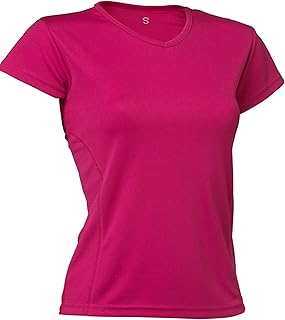

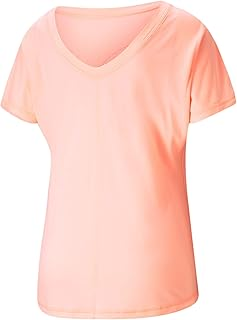

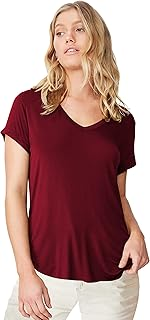

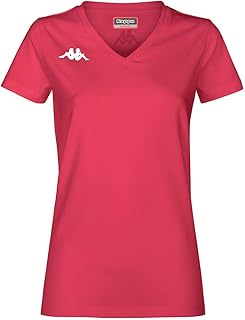

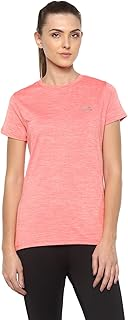

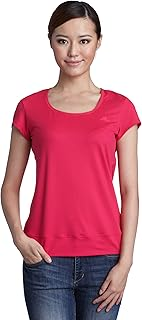

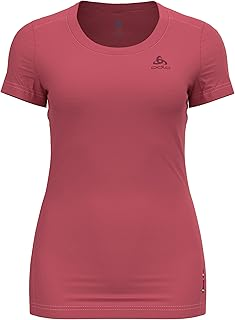

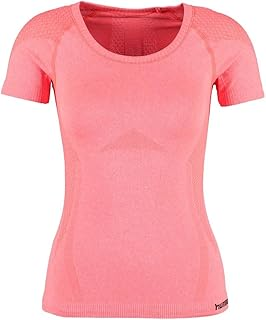

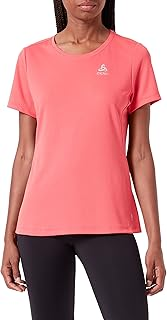

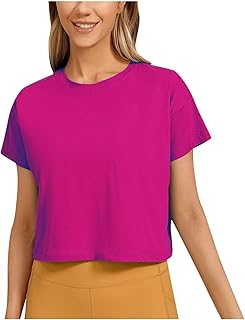

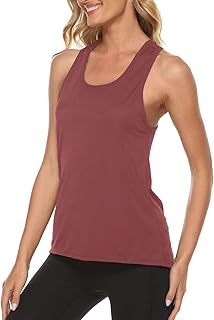

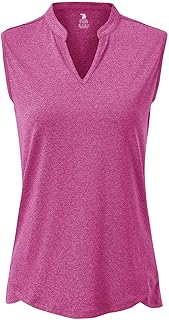

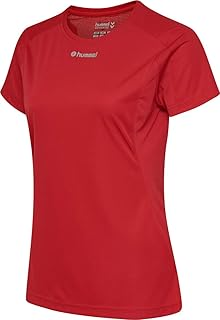

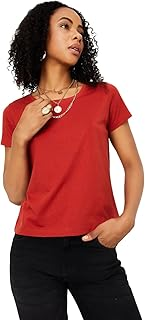

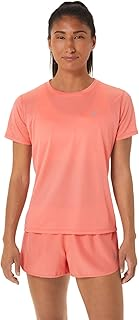

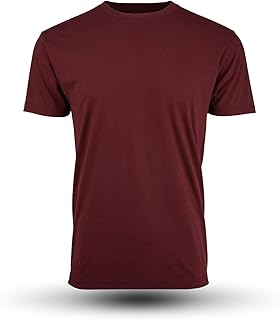

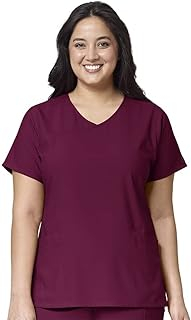

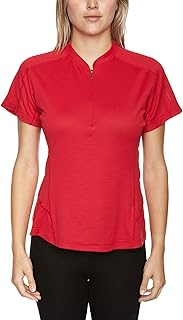

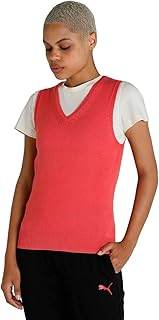

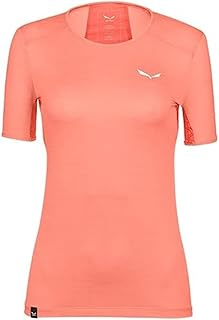

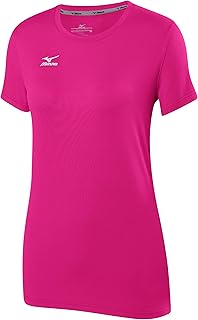

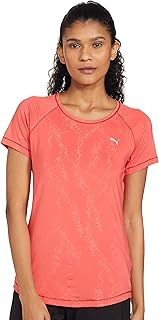

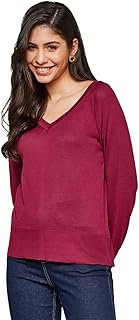

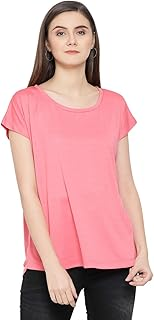

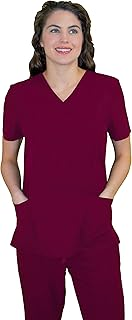

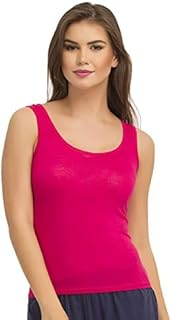

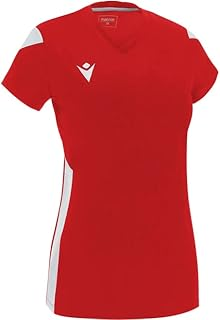

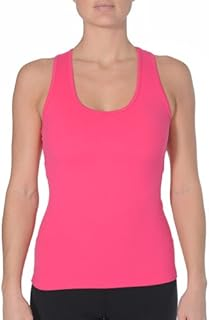

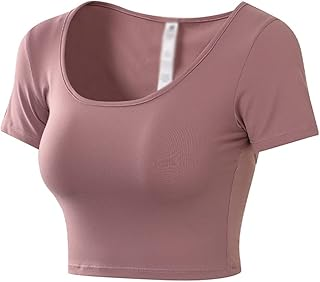

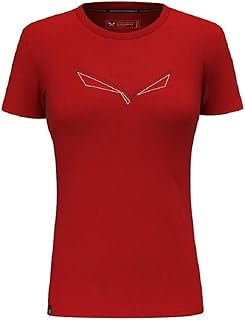

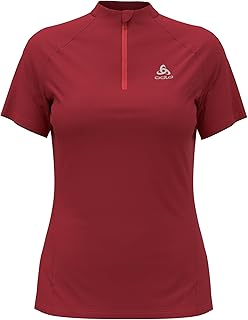

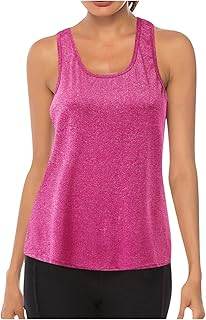

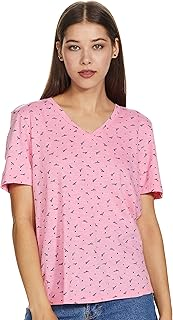

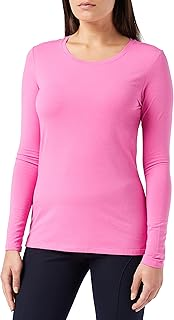

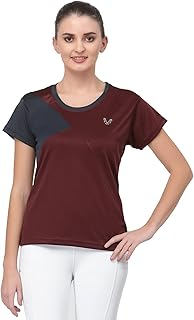

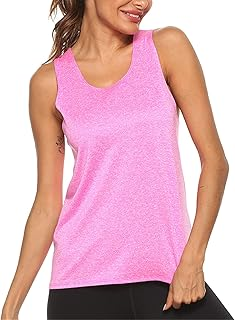

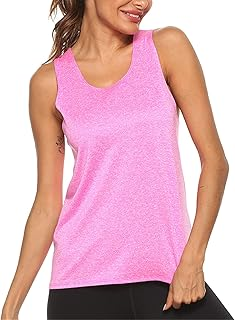

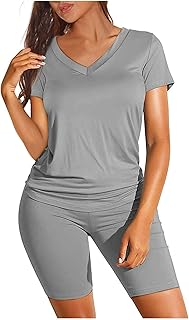

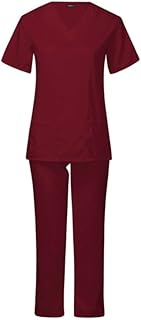

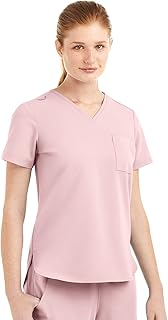

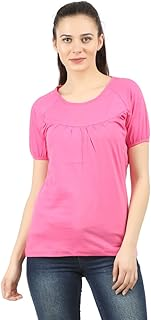

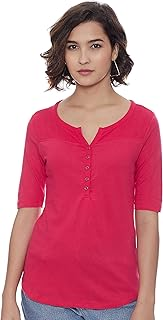

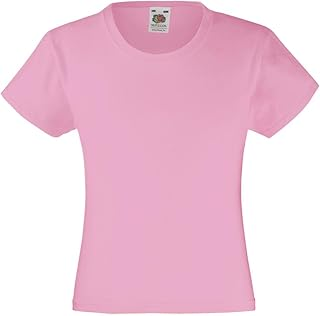

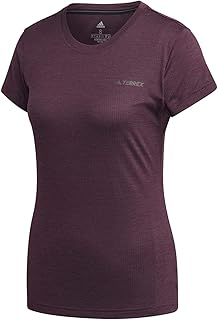

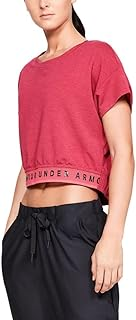

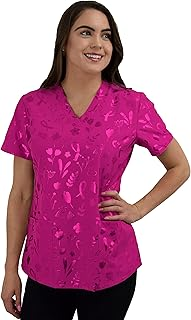

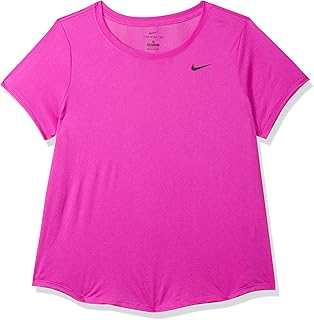

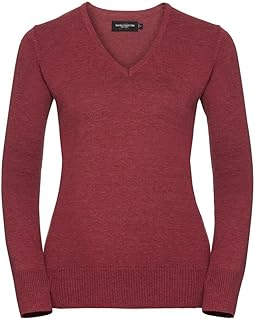

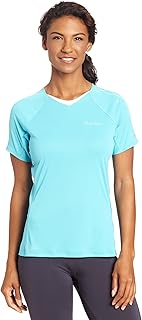

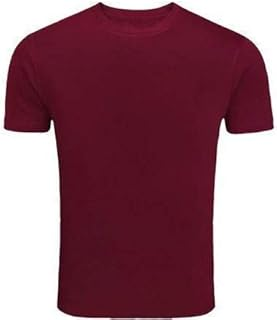

In [51]:
for product in products:
    image =Image.open(product[2])  
    display(image)

# Reranking with Vision Model

Load a reranker model to refine the top 50 results from vector search

In [53]:
# Load proper Qwen3-VL-Reranker-2B with correct configuration
from vllm import LLM, EngineArgs

print("Loading Qwen3-VL-Reranker-2B...")

engine_args = EngineArgs(
    model="Qwen/Qwen3-VL-Reranker-2B",
    runner="pooling",
    dtype="bfloat16",
    trust_remote_code=True,
    gpu_memory_utilization=0.25,
    hf_overrides={
        "architectures": ["Qwen3VLForSequenceClassification"],
        "classifier_from_token": ["no", "yes"],
        "is_original_qwen3_reranker": True,
    },
    max_model_len=2256,
)

reranker_llm = LLM(**vars(engine_args))
import os
from jinja2 import Template

# Official Qwen3-VL-Reranker template (from official Qwen3-VL-Embedding examples)
RERANKER_TEMPLATE = """<|im_start|>system
Judge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be "yes" or "no".<|im_end|>
<|im_start|>user
<Instruct>: {{ instruction }}
<Query>:{{ query_content }}
<Document>:{{ doc_content }}<|im_end|>
<|im_start|>assistant
{{ "" }}"""

def parse_input_dict(input_dict):
    """Parse image/text from input dict, return content string + multimodal data."""
    image = input_dict.get('image')
    text = input_dict.get('text')
    
    mm_data = {'image': []}
    content = ''
    
    if image:
        content += '<|vision_start|><|image_pad|><|vision_end|>'
        if isinstance(image, str):
            # File path - load as PIL Image
            image_obj = Image.open(image).convert("RGB")
            mm_data['image'].append(image_obj)
        else:
            # Already PIL Image
            mm_data['image'].append(image)
    
    if text:
        content += text
    
    return content, mm_data

def format_vllm_reranker_input(query_dict, doc_dict, instruction):
    """Format query and document into official vLLM reranker input."""
    query_content, query_mm_data = parse_input_dict(query_dict)
    doc_content, doc_mm_data = parse_input_dict(doc_dict)
    
    # Combine multimodal data from both query and document
    mm_data = {'image': []}
    mm_data['image'].extend(query_mm_data['image'])
    mm_data['image'].extend(doc_mm_data['image'])
    
    # Render template
    chat_template = Template(RERANKER_TEMPLATE)
    prompt = chat_template.render(
        instruction=instruction,
        query_content=query_content,
        doc_content=doc_content
    )
    
    return {
        'prompt': prompt,
        'multi_modal_data': mm_data
    }

def get_rerank_scores(reranker_llm, query_dict, doc_dicts, instruction):
    """Get reranking scores using official vLLM classify() API."""
    prompts = []
    
    for doc_dict in doc_dicts:
        formatted = format_vllm_reranker_input(query_dict, doc_dict, instruction)
        prompts.append(formatted)
    
    # Use classify() which returns probabilities for "yes"/"no"
    outputs = reranker_llm.classify(prompts=prompts)
    scores = [output.outputs.probs[0] for output in outputs]  # Get "yes" probability
    
    return scores

print("✓ Official vLLM reranker functions defined (uses classify API)")
print("✓ Reranker loaded")

Loading Qwen3-VL-Reranker-2B...
INFO 01-25 12:45:26 [utils.py:263] non-default args: {'runner': 'pooling', 'trust_remote_code': True, 'dtype': 'bfloat16', 'max_model_len': 2256, 'gpu_memory_utilization': 0.25, 'hf_overrides': {'architectures': ['Qwen3VLForSequenceClassification'], 'classifier_from_token': ['no', 'yes'], 'is_original_qwen3_reranker': True}, 'model': 'Qwen/Qwen3-VL-Reranker-2B'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 01-25 12:45:27 [model.py:859] Resolved `--convert auto` to `--convert classify`. Pass the value explicitly to silence this message.
INFO 01-25 12:45:27 [model.py:530] Resolved architecture: Qwen3VLForSequenceClassification
INFO 01-25 12:45:27 [model.py:1545] Using max model len 2256
INFO 01-25 12:45:27 [scheduler.py:229] Chunked prefill is enabled with max_num_batched_tokens=8192.
(EngineCore_DP0 pid=121101) INFO 01-25 12:45:27 [core.py:97] Initializing a V1 LLM engine (v0.14.0) with config: model='Qwen/Qwen3-VL-Reranker-2B', speculative_config=None, tokenizer='Qwen/Qwen3-VL-Reranker-2B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2256, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, enable_return_routed_experts=False, kv_cache_dtype=auto, device_c

(EngineCore_DP0 pid=121101) Process EngineCore_DP0:
(EngineCore_DP0 pid=121101) Traceback (most recent call last):
(EngineCore_DP0 pid=121101)   File "/home/administrator/.local/share/uv/python/cpython-3.13.3-linux-x86_64-gnu/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
(EngineCore_DP0 pid=121101)     self.run()
(EngineCore_DP0 pid=121101)     ~~~~~~~~^^
(EngineCore_DP0 pid=121101)   File "/home/administrator/.local/share/uv/python/cpython-3.13.3-linux-x86_64-gnu/lib/python3.13/multiprocessing/process.py", line 108, in run
(EngineCore_DP0 pid=121101)     self._target(*self._args, **self._kwargs)
(EngineCore_DP0 pid=121101)     ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(EngineCore_DP0 pid=121101)   File "/home/administrator/Desktop/datascience/github/e-commerce-recommendation/.venv/lib/python3.13/site-packages/vllm/v1/engine/core.py", line 940, in run_engine_core
(EngineCore_DP0 pid=121101)     raise e
(EngineCore_DP0 pid=121101)   File "/home/administrator/Deskto

RuntimeError: Engine core initialization failed. See root cause above. Failed core proc(s): {}

In [54]:
import os
from jinja2 import Template

# Official Qwen3-VL-Reranker template (from official Qwen3-VL-Embedding examples)
RERANKER_TEMPLATE = """<|im_start|>system
Judge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be "yes" or "no".<|im_end|>
<|im_start|>user
<Instruct>: {{ instruction }}
<Query>:{{ query_content }}
<Document>:{{ doc_content }}<|im_end|>
<|im_start|>assistant
{{ "" }}"""

def parse_input_dict(input_dict):
    """Parse image/text from input dict, return content string + multimodal data."""
    image = input_dict.get('image')
    text = input_dict.get('text')
    
    mm_data = {'image': []}
    content = ''
    
    if image:
        content += '<|vision_start|><|image_pad|><|vision_end|>'
        if isinstance(image, str):
            # File path - load as PIL Image
            image_obj = Image.open(image).convert("RGB")
            mm_data['image'].append(image_obj)
        else:
            # Already PIL Image
            mm_data['image'].append(image)
    
    if text:
        content += text
    
    return content, mm_data

def format_vllm_reranker_input(query_dict, doc_dict, instruction):
    """Format query and document into official vLLM reranker input."""
    query_content, query_mm_data = parse_input_dict(query_dict)
    doc_content, doc_mm_data = parse_input_dict(doc_dict)
    
    # Combine multimodal data from both query and document
    mm_data = {'image': []}
    mm_data['image'].extend(query_mm_data['image'])
    mm_data['image'].extend(doc_mm_data['image'])
    
    # Render template
    chat_template = Template(RERANKER_TEMPLATE)
    prompt = chat_template.render(
        instruction=instruction,
        query_content=query_content,
        doc_content=doc_content
    )
    
    return {
        'prompt': prompt,
        'multi_modal_data': mm_data
    }

def get_rerank_scores(reranker_llm, query_dict, doc_dicts, instruction):
    """Get reranking scores using official vLLM classify() API."""
    prompts = []
    
    for doc_dict in doc_dicts:
        formatted = format_vllm_reranker_input(query_dict, doc_dict, instruction)
        prompts.append(formatted)
    
    # Use classify() which returns probabilities for "yes"/"no"
    outputs = reranker_llm.classify(prompts=prompts)
    scores = [output.outputs.probs[0] for output in outputs]  # Get "yes" probability
    
    return scores

print("✓ Official vLLM reranker functions defined (uses classify API)")

✓ Official vLLM reranker functions defined (uses classify API)


In [55]:
# Rerank using official vLLM Qwen3-VL-Reranker format
from tqdm import tqdm

print(f"Reranking top 50 products with Qwen3-VL-Reranker-2B (official format)...")

# Prepare query dict (image-only)
query_dict = {"image": query_image}

# Prepare document dicts
doc_dicts = []
for product in products[:50]:
    doc_dicts.append({"image": product[2]})  # image_path

# Get scores using official classify() API
instruction = "Judge whether the product image is visually similar to the query image."
scores = get_rerank_scores(reranker_llm, query_dict, doc_dicts, instruction)

# Build results with scores
reranked_results = []
for idx, (product, score) in enumerate(zip(products[:50], scores)):
    reranked_results.append({
        'id': product[0],
        'title': product[1],
        'image_path': product[2],
        'vector_rank': idx + 1,
        'rerank_score': score
    })

# Sort by rerank score (descending)
reranked_results.sort(key=lambda x: x['rerank_score'], reverse=True)

print(f"\n✓ Reranking complete! Processed {len(reranked_results)} products.")

Reranking top 50 products with Qwen3-VL-Reranker-2B (official format)...


Adding requests:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

INFO 01-25 12:45:39 [loggers.py:257] Engine 000: Avg prompt throughput: 62.4 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Waiting: 0 reqs, GPU KV cache usage: 0.0%, Prefix cache hit rate: 87.1%, MM cache hit rate: 50.7%

✓ Reranking complete! Processed 50 products.


In [56]:
# Compare: Vector Search vs Reranked Results
print("=" * 80)
print("COMPARISON: Vector Search (Top 10) vs Reranked (Top 10)")
print("=" * 80)

print("\n📊 VECTOR SEARCH TOP 10:")
for i, product in enumerate(products[:10]):
    print(f"{i+1}. [Rank {i+1}] {product[1][:70]}")

print("\n" + "="*80)
print("\n🔥 RERANKED TOP 10:")
for i, item in enumerate(reranked_results[:10]):
    print(f"{i+1}. [Was Rank {item['vector_rank']}] Score: {item['rerank_score']:.3f} - {item['title'][:60]}")

print("\n" + "="*80)

COMPARISON: Vector Search (Top 10) vs Reranked (Top 10)

📊 VECTOR SEARCH TOP 10:
1. [Rank 1] ASIOKA Girl's Tagus T-Shirt
2. [Rank 2] महिलाओं की टी शर्ट
3. [Rank 3] महिलाओं के लिए कॉटन V-नेक और गोल नेक अप डाउन शॉर्ट स्लीव टीशर्ट का कॉम
4. [Rank 4] Kappa Women's swimsuit Brizza
5. [Rank 5] 2365-3 हाइड्रा -1 पॉलिएस्टर प्रशिक्षण टी, वयस्क छोटे (पीच)
6. [Rank 6] adidas Essentials Women's Multi-Functional T-Shirt
7. [Rank 7] ODLO Women's Bl Top Crew Neck S/S Merino 130 Top Crew Neck
8. [Rank 8] Hummel Women's T-shirt Eve Seamless Ss Tee T-Shirt
9. [Rank 9] ODLO Women's Polo Shirt S/S F-Dry Polo Shirt
10. [Rank 10] Women T Shirts Summer Tops Woman Causal Round Neck Blouse Short Sleeve


🔥 RERANKED TOP 10:
1. [Was Rank 1] Score: 0.648 - ASIOKA Girl's Tagus T-Shirt
2. [Was Rank 3] Score: 0.588 - महिलाओं के लिए कॉटन V-नेक और गोल नेक अप डाउन शॉर्ट स्लीव टीश
3. [Was Rank 7] Score: 0.470 - ODLO Women's Bl Top Crew Neck S/S Merino 130 Top Crew Neck
4. [Was Rank 39] Score: 0.467 - Scrubs Medical-Unif

🖼️  QUERY IMAGE:


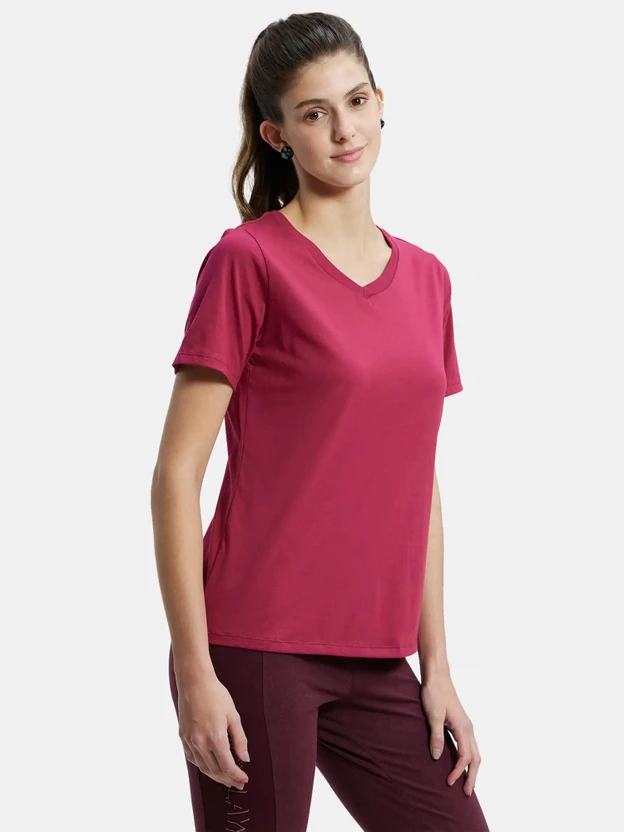


TOP 5 RERANKED RESULTS (by visual similarity score):

1. Rerank Score: 0.648 | Vector Rank: #1
   ASIOKA Girl's Tagus T-Shirt


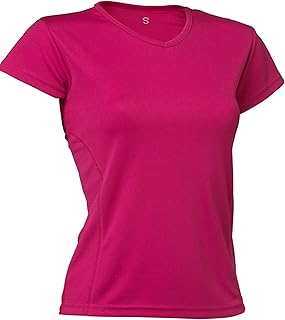


2. Rerank Score: 0.588 | Vector Rank: #3
   महिलाओं के लिए कॉटन V-नेक और गोल नेक अप डाउन शॉर्ट स्लीव टीशर्ट का कॉम्बो, मैरून


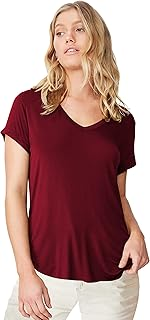


3. Rerank Score: 0.470 | Vector Rank: #7
   ODLO Women's Bl Top Crew Neck S/S Merino 130 Top Crew Neck


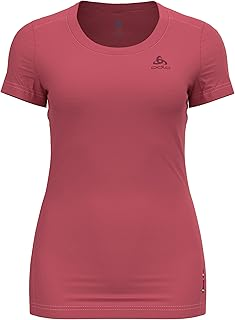


4. Rerank Score: 0.467 | Vector Rank: #39
   Scrubs Medical-Uniform Women and Man Scrubs Set Medical Scrubs Top and Pant


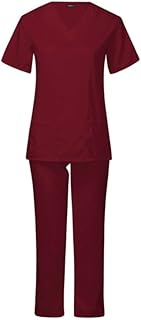


5. Rerank Score: 0.465 | Vector Rank: #2
   महिलाओं की टी शर्ट


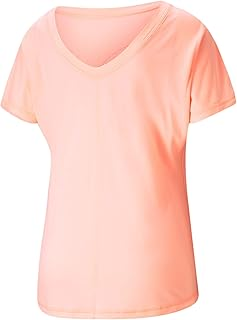

In [57]:
# Visual comparison - show query and top 5 reranked results
print("🖼️  QUERY IMAGE:")
display(query_image)

print("\n" + "="*80)
print("TOP 5 RERANKED RESULTS (by visual similarity score):")
print("="*80)

for i, item in enumerate(reranked_results[:5]):
    print(f"\n{i+1}. Rerank Score: {item['rerank_score']:.3f} | Vector Rank: #{item['vector_rank']}")
    print(f"   {item['title'][:80]}")
    img = Image.open(item['image_path'])
    display(img)